# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as rmse
from tqdm.notebook import tqdm
from IPython.display import clear_output
import random
import math

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 18:43:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  85.3MB/s    in 2.4s    

2021-10-26 18:44:00 (85.3 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.



1.   Для начала импортируем нужные нам библиотеки




In [5]:
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as rmse


2.   Теперь проведем пару манипуляций с данными, чтобы их хоть как-то подготовить, дабы не мучить наш датасет, копипастнем его



In [6]:
X_train_ridge = X_train
y_train_ridge = y_train
X_test_ridge = X_test
y_test_ridge = y_test
df_new = np.concatenate((X_train_ridge, X_test_ridge), axis=0)
print('Размер изначальных данных: ', df.shape, 'Размер новых данных: ', df_new.shape)
train_shape = X_train_ridge.shape[0] # Берем кол-во строк исходного датасета, чтобы потом не потерять значения
print('Кол-во строк в тренировочной выборке: ', train_shape)

# Теперь масштабируем признаки для этого стандарт скалером пройдемся

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_new)
df_new = scaler.transform(df_new)
X_train_ridge = df_new[:train_shape, :]
X_test_ridge = df_new[train_shape:, :]
print('Проверим, что не потеряли строки: ', X_train_ridge.shape[0])
pd.DataFrame(X_train_ridge).head()



Размер изначальных данных:  (515345, 91) Размер новых данных:  (515345, 90)
Кол-во строк в тренировочной выборке:  463715
Проверим, что не потеряли строки:  463715


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,0.793414,-0.584275,-1.056103,-1.045093,-0.805912,-0.747368,-1.055262,-0.858844,-0.873144,-0.903356,-0.666024,-0.836212,-1.008012,-0.734829,-0.423683,-0.504619,0.261180,0.347007,-0.677763,-0.463919,-0.031910,0.144689,0.029940,0.103645,0.171685,-0.676680,-0.198144,-0.443721,0.585406,0.242786,...,-0.339481,-0.429076,0.007435,0.478516,0.050901,-0.310816,0.002206,0.241122,-0.074484,-0.115219,-0.195271,0.155139,-0.272267,0.138797,-0.366056,-0.279650,0.015447,0.371165,-0.035078,0.186311,-0.112104,-0.200706,0.115638,0.302385,0.200496,-0.012610,0.040941,-0.113944,0.251836,0.106465,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,0.541252,-0.265139,0.479611,-0.218605,-1.079941,-0.967624,-0.281324,-0.803477,0.449577,-0.488505,-0.355738,-0.317769,-0.786935,0.165365,-0.193934,-0.151685,0.383939,0.744982,-0.681570,-0.974102,0.123618,0.304598,0.309095,-0.535819,1.049858,-0.424444,-0.605081,-0.352097,0.195786,0.870474,...,0.236999,-0.356714,0.831972,-0.544332,-0.559539,0.240032,-0.079926,-0.326565,-0.499388,-0.262564,-0.794017,-0.401863,0.346923,-0.874203,0.196257,0.092991,-0.916031,0.125195,0.137927,-0.797342,0.218263,0.548457,0.251739,0.125429,0.609536,-0.483539,-0.241197,-0.116109,0.409042,-0.692585,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,0.659382,-0.206489,-1.179183,-0.994540,-0.754449,-0.842576,-1.167197,-0.644427,-0.680438,-0.744836,-1.315763,-0.990010,-0.774182,-0.603851,-0.389326,-0.475469,-0.187041,0.090331,-0.206321,-0.235303,-0.307898,-0.199418,-0.125792,0.578809,0.136693,-0.407285,-0.056498,-0.897922,0.090621,-0.048620,...,0.129665,-0.150860,0.164243,-0.146597,0.026313,-0.034123,0.289001,0.029936,-0.336572,0.194712,-0.099793,0.522931,0.059352,-0.402827,-1.048185,-0.021442,-0.153067,0.460456,-0.279680,-0.026845,0.765419,0.077703,-0.077183,0.873971,-0.154506,0.026094,-0.049322,-0.381945,0.103323,0.315248,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,1.550430,-0.708817,0.176411,-0.151642,-1.006990,-0.965945,-0.353561,-1.126500,-0.679815,-0.867950,-0.691843,-0.902406,-1.016593,-0.918716,0.292010,-0.147141,0.165074,-0.314855,-0.759269,-0.224530,0.094966,-0.662728,-0.656730,-0.736462,0.478642,-0.342991,-0.313003,-0.466669,0.381073,-0.112344,...,-0.019340,-0.874318,-0.123184,0.126595,0.782474,-0.887411,-0.071854,-0.076723,0.373259,0.056994,-0.417653,0.062135,-0.296027,0.615786,-0.224483,-0.221554,-0.863781,-0.299885,-0.507121,0.054858,-0.452187,0.636184,0.315799,0.839595,-0.239151,-0.878425,0.691674,-0.061946,0.478975,0.470511,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,0.401697,-0.042527,0.611278,-0.883220,-0.917862,-1.094474,-1.000481,-0.931815,-0.848601,-0.628978,-0.950142,-0.542465,-1.026901,-0.530277,-0.308223,-0.339436,0.461216,-0.226700,-0.494780,-0.381546,-0.174435,-0.388365,0.150394,-0.301324,0.862572,-0.569401,-0.175053,-0.912897,0.600699,0.027179,...,0.415545,-0.238135,0.215993,-0.226075,-0.369207,-0.514793,-0.204569,-0.518413,-0.547974,0.046413,-0.473956,-0.056385,-0.094789,0.265136,-0.152424,-0.041466,-0.509481,0.318540,-1.215231,-0.319524,0.255035,0.104808,0.499948,-0.316517,0.643128,-0.094951,-0.118654,-0.031379,0.470837,

3.   Ну и теперь обучим спокойненько нашу модельку и посмотрим, помогли ли манипулиции с данными






In [7]:
ridge = lm.Ridge()
ridge.fit(X_train_ridge, y_train_ridge)
y_pred = ridge.predict(X_test_ridge)
print('Ошибка на отмасштабированных данных: ', rmse(y_pred, y_test_ridge, squared=False))
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print('Ошибка на не масштабированных данных:', rmse(y_pred, y_test, squared=False))

Ошибка на отмасштабированных данных:  9.510160818523268
Ошибка на не масштабированных данных: 9.510160711373395


**Вывод**
Поскольку ошибка не очень поменялась даже после масштабирования, давайте писать нейронку :3


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



##  Задание 1. Решение


#### Для начала посмотрим на наши данные
Будем искать пустые значения, в случае чего, менять их, посмотрим как признаки коррелируют с целевой переменной и проведем предобработку данных. Может, даже почистим от выбросов


In [8]:
table = df.isnull().sum(axis=0) # Считаем наны по столбцам
np.count_nonzero(table) # Ищем, есть ли вообще ненулевые столбцы (в которых есть наны)

0

Нанов у нас в датафрейме нет, уже приятно


In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (25.0, 7.0)

In [10]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

#### Масштабирование
Теперь отмасштабируем данные, для этого воспользуемся StandartScaler. Сохраним в дополнительный список значения стандартного отклонения и среднего по целевой переменной, чтобы потом спокойненько привести нашу ошибку и предсказания к адекватному виду

Масштабируем признаки:


In [11]:
X_train_1 = X_train
y_train_1 = y_train
X_test_1 = X_test
y_test_1 = y_test
df_new = np.concatenate((X_train_1, X_test_1), axis=0)
df_y = np.concatenate((y_train_1, y_test_1), axis=0)
print('Размер изначальных данных: ', df.shape, 'Размер новых данных: ', df_new.shape)
train_shape = X_train_1.shape[0] # Берем кол-во строк исходного датасета, чтобы потом не потерять значения
print('Кол-во строк в тренировочной выборке: ', train_shape)


# Теперь масштабируем признаки для этого стандарт скалером пройдемся

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_new)
df_new = scaler.transform(df_new)
X_train_1 = df_new[:train_shape, :]
X_test_1 = df_new[train_shape:, :]
print('Проверим, что не потеряли строки: ', X_train_1.shape[0])
pd.DataFrame(X_train_1).head()

Размер изначальных данных:  (515345, 91) Размер новых данных:  (515345, 90)
Кол-во строк в тренировочной выборке:  463715
Проверим, что не потеряли строки:  463715


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,0.793414,-0.584275,-1.056103,-1.045093,-0.805912,-0.747368,-1.055262,-0.858844,-0.873144,-0.903356,-0.666024,-0.836212,-1.008012,-0.734829,-0.423683,-0.504619,0.261180,0.347007,-0.677763,-0.463919,-0.031910,0.144689,0.029940,0.103645,0.171685,-0.676680,-0.198144,-0.443721,0.585406,0.242786,...,-0.339481,-0.429076,0.007435,0.478516,0.050901,-0.310816,0.002206,0.241122,-0.074484,-0.115219,-0.195271,0.155139,-0.272267,0.138797,-0.366056,-0.279650,0.015447,0.371165,-0.035078,0.186311,-0.112104,-0.200706,0.115638,0.302385,0.200496,-0.012610,0.040941,-0.113944,0.251836,0.106465,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,0.541252,-0.265139,0.479611,-0.218605,-1.079941,-0.967624,-0.281324,-0.803477,0.449577,-0.488505,-0.355738,-0.317769,-0.786935,0.165365,-0.193934,-0.151685,0.383939,0.744982,-0.681570,-0.974102,0.123618,0.304598,0.309095,-0.535819,1.049858,-0.424444,-0.605081,-0.352097,0.195786,0.870474,...,0.236999,-0.356714,0.831972,-0.544332,-0.559539,0.240032,-0.079926,-0.326565,-0.499388,-0.262564,-0.794017,-0.401863,0.346923,-0.874203,0.196257,0.092991,-0.916031,0.125195,0.137927,-0.797342,0.218263,0.548457,0.251739,0.125429,0.609536,-0.483539,-0.241197,-0.116109,0.409042,-0.692585,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,0.659382,-0.206489,-1.179183,-0.994540,-0.754449,-0.842576,-1.167197,-0.644427,-0.680438,-0.744836,-1.315763,-0.990010,-0.774182,-0.603851,-0.389326,-0.475469,-0.187041,0.090331,-0.206321,-0.235303,-0.307898,-0.199418,-0.125792,0.578809,0.136693,-0.407285,-0.056498,-0.897922,0.090621,-0.048620,...,0.129665,-0.150860,0.164243,-0.146597,0.026313,-0.034123,0.289001,0.029936,-0.336572,0.194712,-0.099793,0.522931,0.059352,-0.402827,-1.048185,-0.021442,-0.153067,0.460456,-0.279680,-0.026845,0.765419,0.077703,-0.077183,0.873971,-0.154506,0.026094,-0.049322,-0.381945,0.103323,0.315248,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,1.550430,-0.708817,0.176411,-0.151642,-1.006990,-0.965945,-0.353561,-1.126500,-0.679815,-0.867950,-0.691843,-0.902406,-1.016593,-0.918716,0.292010,-0.147141,0.165074,-0.314855,-0.759269,-0.224530,0.094966,-0.662728,-0.656730,-0.736462,0.478642,-0.342991,-0.313003,-0.466669,0.381073,-0.112344,...,-0.019340,-0.874318,-0.123184,0.126595,0.782474,-0.887411,-0.071854,-0.076723,0.373259,0.056994,-0.417653,0.062135,-0.296027,0.615786,-0.224483,-0.221554,-0.863781,-0.299885,-0.507121,0.054858,-0.452187,0.636184,0.315799,0.839595,-0.239151,-0.878425,0.691674,-0.061946,0.478975,0.470511,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,0.401697,-0.042527,0.611278,-0.883220,-0.917862,-1.094474,-1.000481,-0.931815,-0.848601,-0.628978,-0.950142,-0.542465,-1.026901,-0.530277,-0.308223,-0.339436,0.461216,-0.226700,-0.494780,-0.381546,-0.174435,-0.388365,0.150394,-0.301324,0.862572,-0.569401,-0.175053,-0.912897,0.600699,0.027179,...,0.415545,-0.238135,0.215993,-0.226075,-0.369207,-0.514793,-0.204569,-0.518413,-0.547974,0.046413,-0.473956,-0.056385,-0.094789,0.265136,-0.152424,-0.041466,-0.509481,0.318540,-1.215231,-0.319524,0.255035,0.104808,0.499948,-0.316517,0.643128,-0.094951,-0.118654,-0.031379,0.470837,

Масштабируем и таргет и сохраняем нужные коэффициенты:


In [12]:
scaler_y = StandardScaler()
df_y = df_y.reshape(-1, 1)
scaler_y.fit(df_y)
df_y = scaler_y.transform(df_y)
y_train_1 = df_y[:train_shape]
y_test_1 = df_y[train_shape:]
y_coefs = [float(scaler_y.mean_), float(scaler_y.scale_[0])]      # Список с нашими скейлами, чтобы потом использовать в ошибке

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

#### Модель

Теперь пропишем класс датасета и класс модели, в отдельных ячейках, чтобы потом проще было менять архитектуру модели.

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float),  torch.tensor(self.y[idx], dtype=torch.float)

In [14]:
set_random_seed(30)
train_set = Dataset(X_train_1, y_train_1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

test_set = Dataset(X_test_1, y_test_1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

model = torch.nn.Sequential(
          torch.nn.Linear(90, out_features=60),
          torch.nn.LeakyReLU(),
          torch.nn.Dropout(p=0.2),
          torch.nn.Linear(60, 50),
          torch.nn.Sigmoid(),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(50, 1))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
criterion = torch.nn.MSELoss()

In [15]:
def plot_history(train_history, test_history, title='LOSS'):
    clear_output(wait=True)
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, c='b', marker='o', label='train', zorder=1)

    plt.plot(test_history, marker='o', c='orange', label='test', zorder=2)
    plt.xlabel('Epoch')

    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [21]:
def train(model, optimizer, criterion, train_loader, test_loader, N):                             #Добавили дополнительно N - количество эпох для обучения 
    counter_train = []
    counter_test = []
    for epoch in range(N):
        running_loss = []
        test_loss = []
        model.train()
        for x_train, y_train in tqdm(train_loader):                                               #Начинаем тренировать на трейне   
            y_pred = model(x_train) 
            loss = criterion((y_pred*y_coefs[1]+y_coefs[0]), (y_train*y_coefs[1]+y_coefs[0]))     #Здесь приводим ошибку в нормальный вид из нашего старого списка наверху                  
            loss.backward()                         
            optimizer.step()                               
            optimizer.zero_grad()
            running_loss.append(loss.item())
        model.eval()
        with torch.no_grad():
            for x_test, y_test in tqdm(test_loader):                                               #Чисто считать ошибку на тестовой выборке
                y_pred = model(x_test)
                loss = criterion((y_pred*y_coefs[1]+y_coefs[0]), (y_test*y_coefs[1]+y_coefs[0]))                       
                test_loss.append(loss.item())
        counter_train.append(math.sqrt(sum(running_loss)/len(train_loader)))
        counter_test.append(math.sqrt(sum(test_loss)/len(test_loader)))
        plot_history(counter_train, counter_test)
        print('epoch: ', epoch+1)
        print('train loss: ', math.sqrt(sum(running_loss)/len(train_loader)))
        print('test loss: ', math.sqrt(sum(test_loss)/len(test_loader)))


def test(model, test_loader):                   # Функция теста будет возвращать предикты на тестовом наборе данных
    
    predicts = model(test_loader.dataset[:][0])*y_coefs[1]+y_coefs[0]
    return predicts

Проверим, как считается наша ошибка в функции трейна:

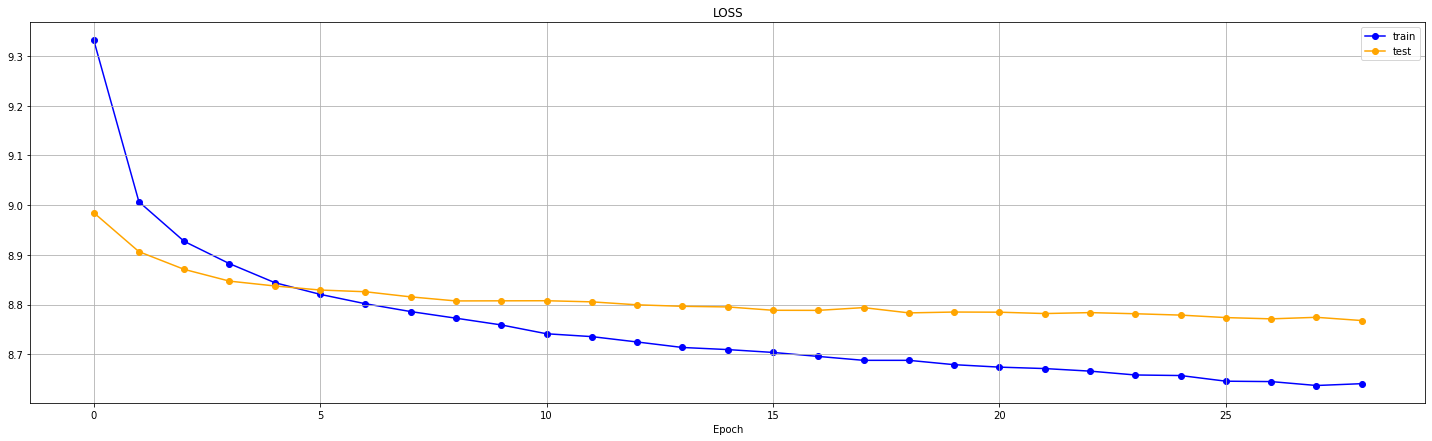

epoch:  29
train loss:  8.640764349423257
test loss:  8.767775780894013


In [17]:
train(model, optimizer, criterion, train_loader, test_loader, N=29)

In [22]:
assert test(model, test_loader).shape[0] == y_test.shape[0]

In [23]:
test(model, test_loader)

tensor([[1999.9319],
        [2002.7843],
        [2001.0184],
        ...,
        [1999.9810],
        [2000.9202],
        [2002.4825]], grad_fn=<AddBackward0>)

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Отчет
Что ж, теперь давайте подведем итоги.
Работа была интересной и продуктивной. В рамках этой работы пришлось помучиться и повозиться с правильной реализацией нейронной сети.
К счастью масштабировать целевую переменную мне пришло в голову раньше, чем об этом сказали на курсе, но я долго ошибался в обратном скейле из-за чего ошибка долго не хотела падать. Некоторые вещи, вероятно, можно было прописывать легче. например считать раннинг лосс не внутри списков, а тензорами или арреями. Но модель реаботает и выдает хорошее качество. К тому же на данном объеме данных это не сильно сказывается на скорости. Поэтому я не стал гневить Бога и оставил как есть.
Теперь поговорим немного об архитектуре, о том, как она себя вела и как я ее улучшал. Опишу несколько основных этапов, которые помогли прийти к такому результату:
  - Сначала я долго подбирал параметры на очень небольшом количестве батчей (5-15 штук), однако это не давало спустить качество модели до приемлемого, вероятно потому что небольшое количество несправлялось с довольно объемным набором признаков и не давало должное разнообразие результатов.
  - После того, как я увеличил количество батчей и методом пристального взгляда смог-таки подобрать число 100 для них, встал вопрос об архитектуре. Здесь стоит отметить, что примерная архитектура (3 полносвязных слоя, ReLU в качестве нелинейности было понятно сразу), однако с количеством in_features, out_features пришлось повозиться и провести ряд тестов, подбирая оптимальные варианты в промежутке (30, 70) для первого стоя и такого же для второго слоя. Касательно функций активации, пришлось поизучать и перепробовать много разных **ReLU**, почитать про плюсы и минусы различных функций активации. Тут мне очень помог небольшой [гайд](http://datareview.info/article/eto-nuzhno-znat-klyuchevyie-rekomendatsii-po-glubokomu-obucheniyu-chast-2/). Экспериментальным путем я дошел до того, что **LeakyReLU** больше всего помогает быстро и до нужного момента снижать ошибку. Еще одним важным решением было добавить вторую функцию активации (сигмоиду) чтобы резко улучшить качество, почему конкретно здесь подошла сигмоида, честно говоря, я сам до конца не понял, но перепробовал все и все красиво получилось только с сигмоидой.
  - Касательно последнего важного для качества модели шага - им стал простой подбор нужного количества эпох. Когда я нащупал нужную модель (и пришлось прямо полапать здраво), я стал учить модель на огромном количестве эпох (максимально дожидался 64) дожидаясь хорошего качества и момента, когда лосс упадет до нужного значения и там останется, затем задал как гиперпараметр. Здесь все довольно просто и очевидно.
  - Касательно оптимизатора вопросов особо не возникало. На просторах интернета, да и в рамках обсуждений происходящих на курсе довольно часто упоминается **Adam** как лучший вариант. Что ж, в первые пару тестов я пробовал стохастический градиентный спуск, но довольно быстро ушел от него, вопрос оставался за регуляризатором и длиной шага. Вообще лучший результат модели был *8.75* при длине шага 0.001, но я налажал с рандом сидом и поэтому немного его понизил, 0.0007 сразу показал себя хорошим вариантом. В какой-то момент, начинала расти ошибка на тестовых данных и резко снижаться на тренировочных, тогда логичной мыслью стало добавить регуляризатор к моей модели. Сначала я пробовал добавить классический **weight_decay**, но перепробовав в нем большое количество вариантов (от сравнительно небольших, то 0,1) оказалось, что это может и спасает от переобучения, но теперь ошибка фиксировалась на просто неприемлемом уровне. Тут на помощь пришел [**DropOut**](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) . О нем я узнал из подсказки, заботливо оставленной в сообщении в канале курса. Оставалось подобрать подходящее ***р*** методом научного тыка.
  - Еще одно важное замечание. Не совсем понял в рамках данной модели, чем так прекрасна **RReLU** потому что в нашем случае она показывала себя хуже самого базового варианта. Может, я просто не подобрал подходящее значение для него.

В конце хотелось бы сказать спасибо, что терпите наш нескончаемый тупизм и наглость, отвечаете в любое время и доходчиво объясняете.
Это дорогого стоит, я это понимаю, и простите, если в моменте, мы вас можем разочаровать. Мы вас ценим и любим. :з
